# Time Series Analysis - Part 4 :  ARCH and GARCH models

We will discuss conditional heteroskedasticity, leading us to our first conditional heteroskedastic model, known as ARCH. Then we will discuss extensions to ARCH, leading us to the famous Generalised Autoregressive Conditional Heteroskedasticity model of order p,q, also known as GARCH(p,q). GARCH is widely used within the financial industry as many asset prices are conditional heteroskedastic.


The final piece to the puzzle is to examine conditional heteroskedasticity in detail and apply GARCH to some financial series that exhibit volatility clustering.

In [ ]:
!pip install arch
!pip install yahooquery

In [6]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

from yahooquery import Ticker
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [8]:
def fetch_yahoo_data(ticker: str, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    """
    Downloads historical data for a financial asset from Yahoo Finance using yahooquery.

    Parameters:
    - ticker (str): Asset symbol (e.g., 'AAPL' for Apple, 'TSLA' for Tesla).
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - interval (str, optional): Time interval ('1d', '1wk', '1mo', '1h', etc.).
      Possible values: ['1m', '2m', '5m', '15m', '30m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    Returns:
    - pd.DataFrame: DataFrame with columns ['open', 'high', 'low', 'close', 'adjclose', 'volume'].
    """
    try:
        asset = Ticker(ticker)
        data = asset.history(start=start_date, end=end_date, interval=interval)
        if data.empty:
            raise ValueError("No data found for the specified date range.")
        return data.reset_index()
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [9]:
def fetch_closing_prices(tickers: list, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    """
    Fetches the closing prices for multiple tickers and returns a DataFrame.

    Parameters:
    - tickers (list): List of asset symbols.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - interval (str, optional): Time interval ('1d', '1wk', '1mo', '1h', etc.).

    Returns:
    - pd.DataFrame: DataFrame where each column is a ticker and rows represent closing prices over time.
    """
    closing_prices = pd.DataFrame()
    for ticker in tickers:
        data = fetch_yahoo_data(ticker, start_date, end_date, interval)
        if not data.empty:
            closing_prices[ticker] = data.set_index("date")["close"]
    return closing_prices

In [10]:
# Usage example
if __name__ == "__main__":
    tickers = ["AAPL", "MSFT", "^GSPC"]
    start_date = "2008-01-01"
    end_date = "2025-01-01"
    data = fetch_closing_prices(tickers, start_date, end_date)
    print(data.head())

/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/usr/local/lib/python3.11/dist-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a Dat

                AAPL       MSFT        ^GSPC
date                                        
2008-01-02  6.958571  35.220001  1447.160034
2008-01-03  6.961786  35.369999  1447.160034
2008-01-04  6.430357  34.380001  1411.630005
2008-01-07  6.344286  34.610001  1416.180054
2008-01-08  6.116071  33.450001  1390.189941


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


In [62]:
lrets = np.log(data / data.shift(1)).fillna(0)
lrets.columns = ['AAPL', 'MSFT','SPX']

In [11]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    """
    Generates a set of diagnostic plots for a time series.

    Parameters:
    - y (array-like or pd.Series): Time series data.
    - lags (int, optional): Number of lags to include in the ACF and PACF plots.
    - figsize (tuple, optional): Figure size, default is (15, 10).
    - style (str, optional): Matplotlib style for plotting, default is 'bmh'.

    The function generates the following plots:
    1. Time series plot.
    2. Autocorrelation function (ACF) plot.
    3. Partial autocorrelation function (PACF) plot.
    4. Quantile-Quantile (QQ) plot for normality assessment.
    5. Probability plot.

    Returns:
    - None: Displays the plots.

    Example:
    >>> import numpy as np
    >>> import pandas as pd
    >>> np.random.seed(42)
    >>> data = np.random.randn(100)
    >>> tsplot(pd.Series(data), lags=20)
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## Conditional Heteroskedasticity

The main motivation for studying conditional heteroskedasticity in finance is that of volatility of asset returns.

A collection of random variables is **heteroskedastic** if there are certain groups, or subsets, of variables within the larger set that have a different variance from the remaining variables.

In finance, an increase in variance maybe correlated to a further increase in variance. For instance, on a day that equities markets undergo a substantial drop, automated risk management sell orders in long only portfolios get triggered, which lead to further fall in the price of equities within these portfolios, leading to significant downward volatility.

These "sell-off" periods, as well as many other forms of volatility, lead to heteroskedasticity that is serially correlated and hence conditional on periods of increased variance. Thus we say that such series are conditional heteroskedastic.

One of the challenging aspects of conditional heteroskedastic series is ACF plots of a series with volatility might still appear to be a realisation of stationary discrete white noise. This is despite the fact that the series is most definitely non-stationary as its variance is not constant in time.

To incorporate CH in our model, we can create a model that utilises an autoregressive process for the variance itself - a model that actually accounts for the changes in the variance over time using past values of the variance.

This is the basis of the Autoregressive Conditional Heteroskedastic (ARCH) model.


## Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series.

$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+…+\alpha_pVar(\epsilon_{t-p})+w_t$$

The actual time series is given by:

$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+…+\alpha_p\epsilon_{t-p}^2}$$

For ARCH(1), this reads:
$$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

### When To Apply ARCH(p)?

When we were attempting to fit an AR(p) model and are concerned with the decay of the $p$ lag on a ACF plot of the series, we can apply the same logic to the square of the residuals. If we find that we can apply an AR(p) to these square residuals then we have an indication that an ARCH(p) process may be appropriate.

**Note that ARCH(p) should only ever be applied to a series that has already had an appropriate model fitted sufficient to leave the residuals looking like discrete white noise**. Since we can only tell whether ARCH is appropriate or not by squaring the residuals and examining the ACF, we also need to ensure that the mean of the residuals is zero.

ARCH should only ever be applied to series that do not have any trends or seasonal effects, i.e. that has no (evident) serially correlation. ARIMA is often applied to such a series, at which point ARCH may be a good fit.



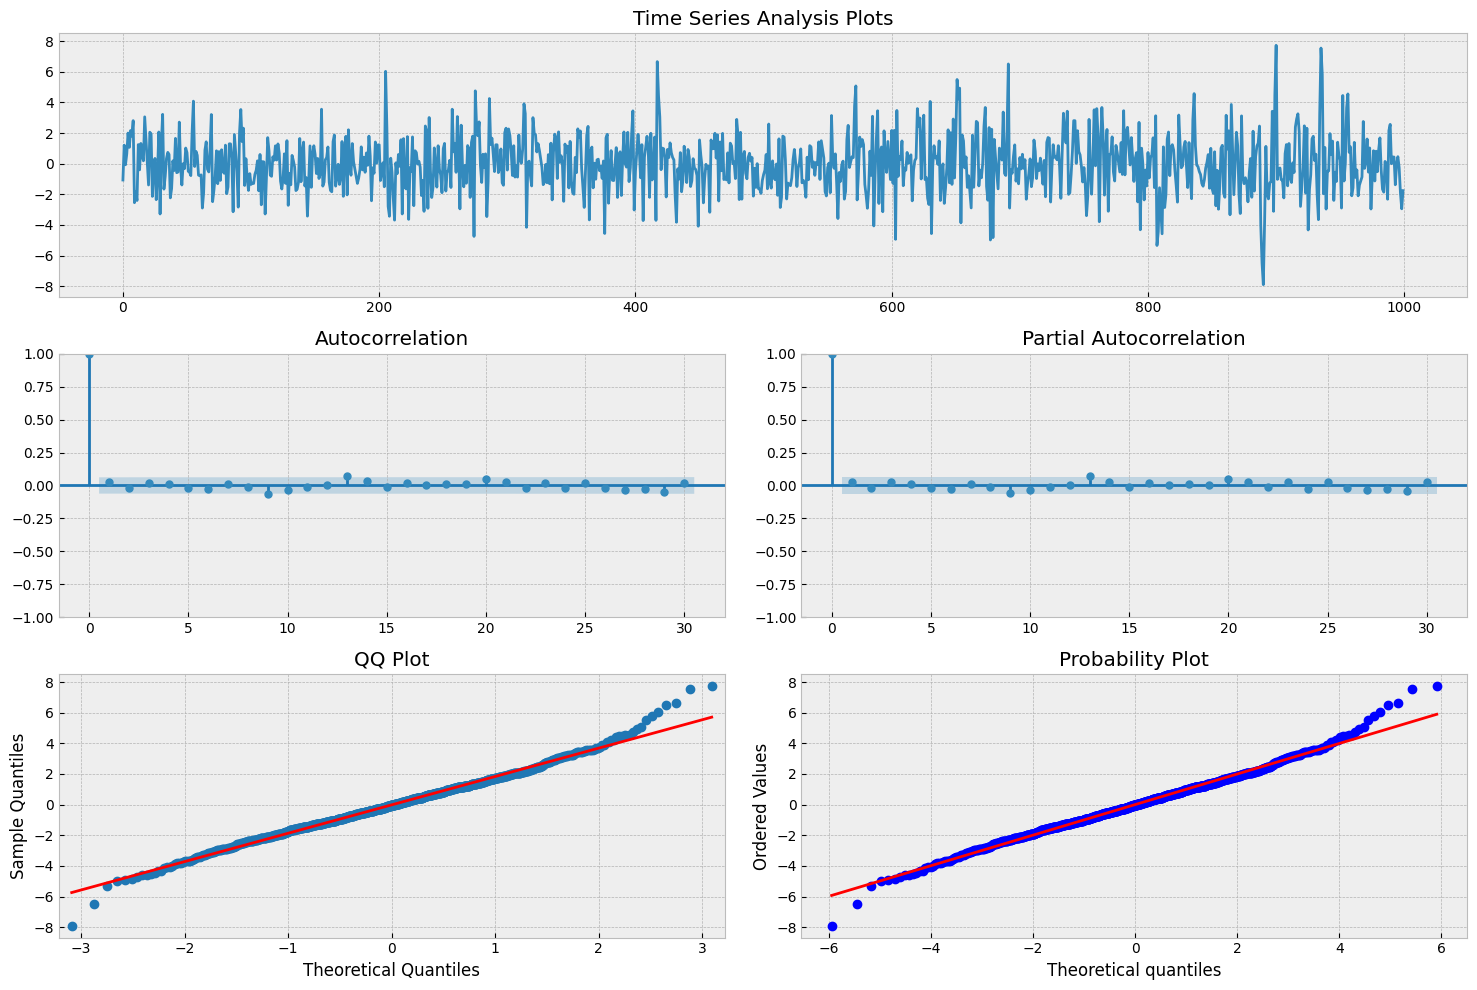

In [13]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)

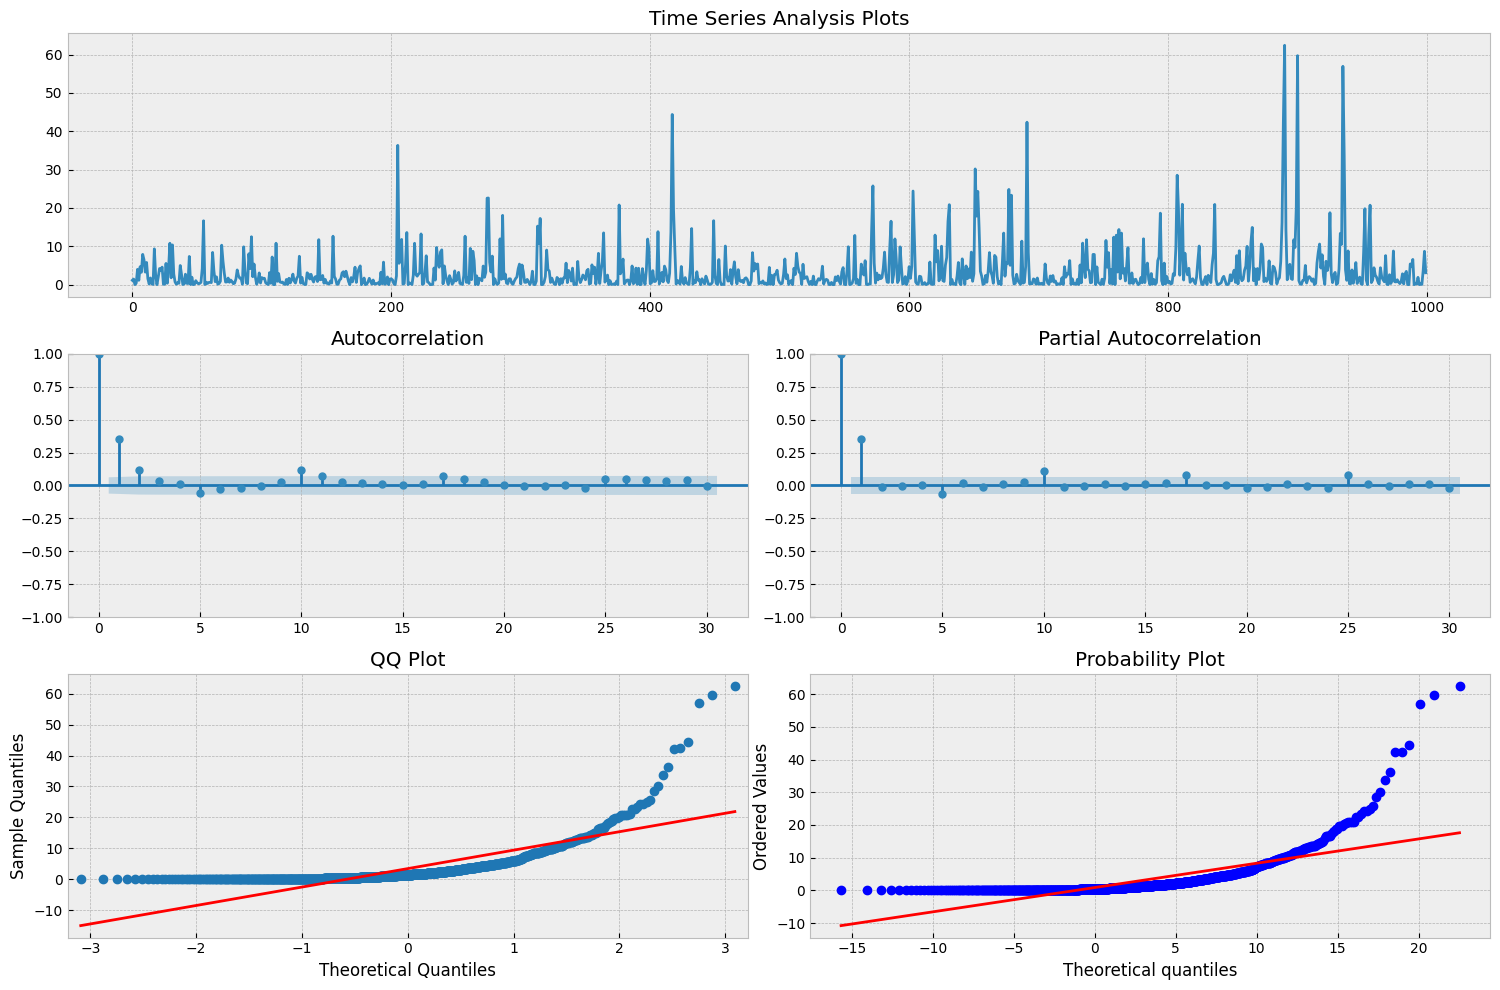

In [14]:
tsplot(y**2, lags=30)

Notice the time series looks just like white noise. However, when we plot the square of the series, the ACF, and PACF  seem to show significance at lag 1 indicating an AR(1) model for the variance may be appropriate.

## Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process.

$$\epsilon_t = \sigma_t w_t$$

Where $w_t$ is discrete white noise, with zero mean and unit variance, and $\sigma^2$ is given by:

$$\sigma_t^2=\alpha_0+\sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^{q}\beta_j\sigma_{t-j}^2$$

Where $\alpha_i$ and $\beta_j$ are parameters of the model.For GARCH(1,1), $\sigma^2$ is:

$$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\alpha_1 + \beta_1$ must be less than 1 or the model is unstable. We can simulate a GARCH(1, 1) process below.

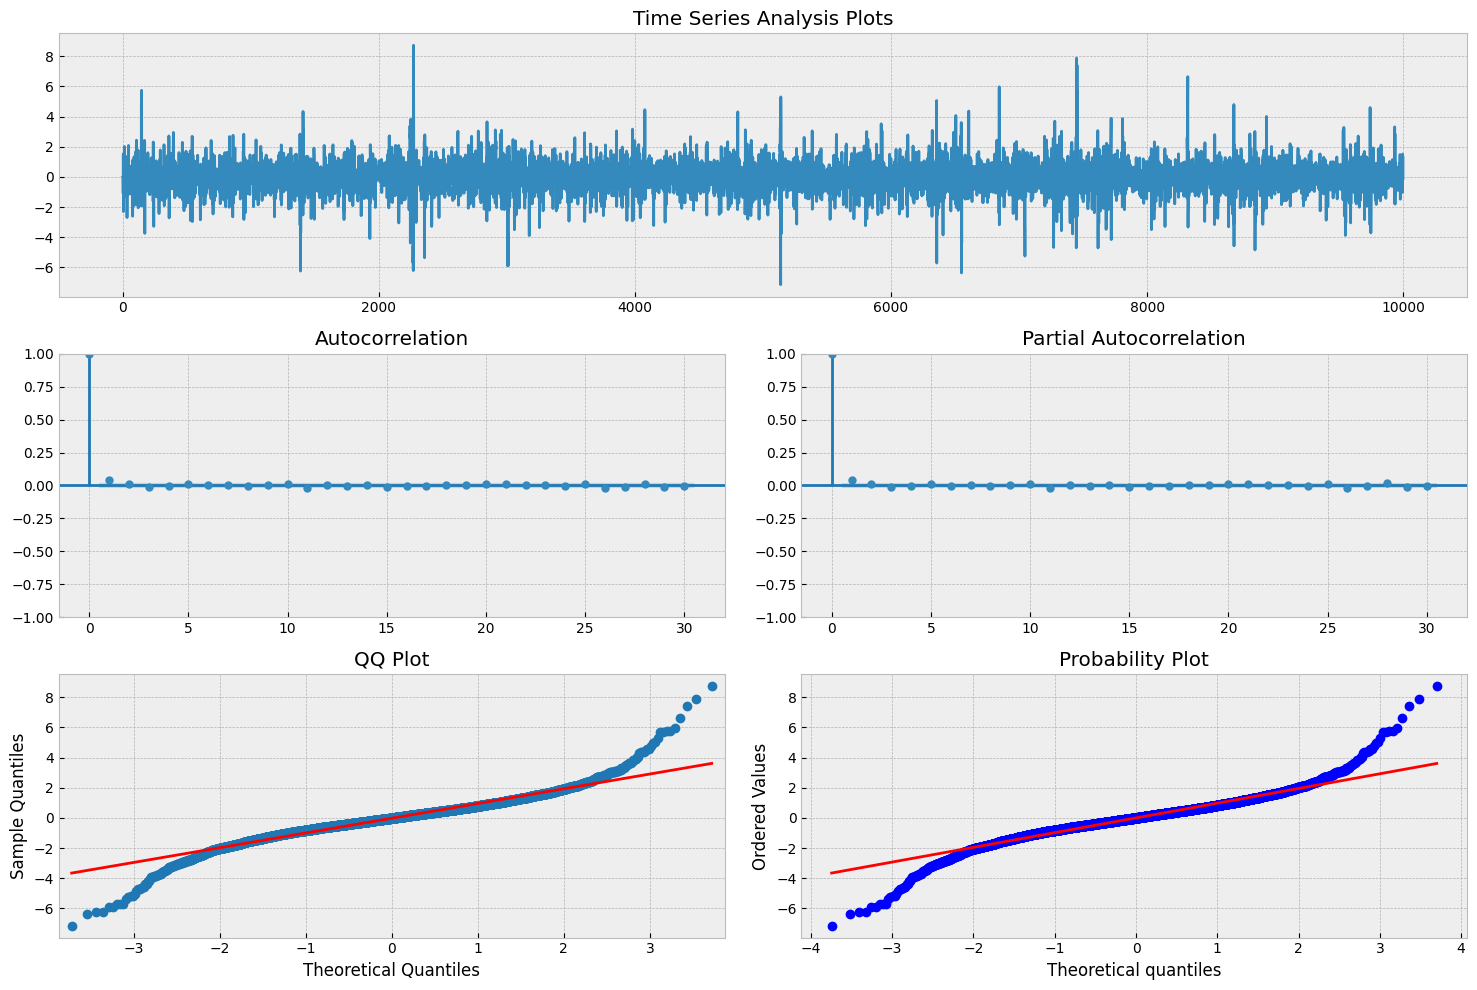

In [16]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

Again, notice that overall this process closely resembles white noise, however take a look when we view the squared eps series.

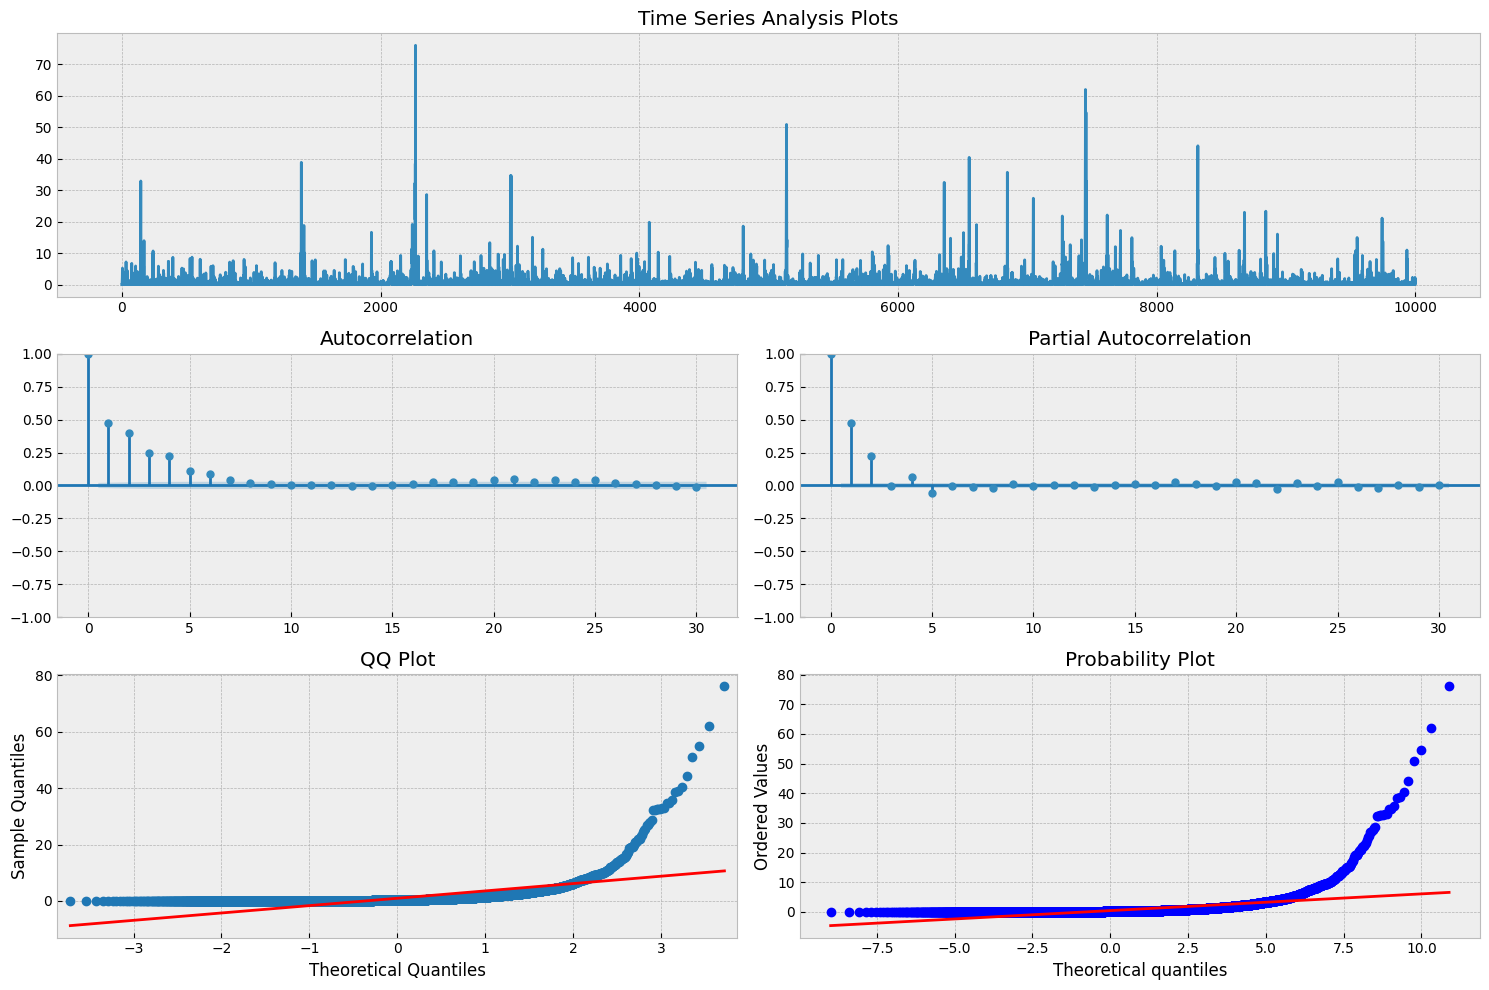

In [17]:
_ = tsplot(eps**2, lags=30)

There is substantial evidence of a conditionally heteroskedastic process via the decay of successive lags. The significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model. Let's see if we can recover our process parameters using a GARCH(1, 1) model. Here we make use of the arch_model function from the ARCH package.

In [ ]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.7936836
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.5926591
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.3032673
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Mon, Dec 31 2018   Df Residuals:                     9996
Time:                     

We can see that the true parameters all fall within the respective confidence intervals.

## Application to Financial Time Series

Now apply the procedure to a financial time series. Here we're going to use SPX returns. The process is as follows:

* Iterate through combinations of ARIMA(p, d, q) models to best fit our time series.
* Pick the GARCH model orders according to the ARIMA model with lowest AIC.
* Fit the GARCH(p, q) model to our time series.
* Examine the model residuals and squared residuals for autocorrelation


Here, we first try to fit SPX return to an ARIMA process and find the best order.

In [ ]:
def _get_best_model(TS):
    """
    Finds the best ARIMA model for a time series based on the AIC criterion.

    Parameters:
    - TS (pd.Series): Time series with a DatetimeIndex.

    Returns:
    - best_aic (float): Best AIC value found.
    - best_order (tuple): (p, d, q) order of the best ARIMA model.
    - best_mdl (statsmodels.tsa.arima.model.ARIMAResults): Fitted ARIMA model object.

    The function tests combinations of ARIMA orders within the following ranges:
    - p (autoregressive order): [0, 1, 2, 3, 4]
    - d (differencing order): [0, 1]
    - q (moving average order): [0, 1, 2, 3, 4]

    Each model is fitted using `statsmodels.tsa.ARIMA.fit()` with `method='mle'`
    and `trend='nc'` (no constant). The model with the lowest AIC is selected.

    Example usage:
    ```python
    TS = pd.Series(data, index=pd.date_range("2024-01-01", periods=len(data)))
    best_aic, best_order, best_mdl = _get_best_model(TS)
    ```
    """
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets['SPX'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: -5188.75603 | order: (4, 0, 0)


/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [72]:
order = res_tup[1]
model = res_tup[2]

Since we've already taken the log of returns, we should expect our integrated component d to equal zero, which it does. We find the best model is ARIMA(3,0,2).
Now we plot the residuals to decide if they possess evidence of conditional heteroskedastic behaviour

In [ ]:
tsplot(model.resid, lags=30)

We find the reiduals look like white noise. Let's look at the square of residuals

In [ ]:
tsplot(model.resid**2, lags=30)

We can see clear evidence of autocorrelation in squared residuals. Let's fit a GARCH model and see how it does.

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                         None   R-squared:                -3819681.668
Mean Model:                   Constant Mean   Adj. R-squared:           -3819681.668
Vol Model:                             ARCH   Log-Likelihood:               -4471.70
Distribution:      Standardized Student's t   AIC:                           8957.40
Method:                  Maximum Likelihood   BIC:                           8989.79
                                              No. Observations:                  755
Date:                      Mon, Dec 31 2018   Df Residuals:                      748
Time:                              15:56:34   Df Model:                            7
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           -15

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/arch/univariate/base.py:517: ConvergenceWarning:


The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Let's plot the residuals again

In [ ]:
tsplot(res.resid, lags=30)

The plots looks like a realisation of a discrete white noise process, indicating a good fit. Let's plot a square of residuals to be sure

In [ ]:
tsplot(res.resid**2, lags=30)

We have what looks like a realisation of a discrete white noise process, indicating that we have "explained" the serial correlation present in the squared residuals with an appropriate mixture of ARIMA(p,d,q) and GARCH(p,q).